In [76]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import grad, jit

In [58]:
_eps = 1e-16

def softmax(x):
    """
    Compute the softmax of a vector x. Will compute column-wise softmax if x is a 2-D matrix.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [59]:
# shapes by column ['square', 'circle', 'triangle']

# output given states/shapes matrices 
light_blue_shapes_os = np.asarray([
    [9/10, 5/100, 5/100],
    [5/100, 9/10, 5/100],
    [5/100, 5/100, 9/10]
])

light_green_shapes_os = np.asarray([
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3]
])

# A = np.kron(light_blue_shapes_os, light_green_shapes_os)
# A.shape

In [55]:
# A = np.kron(light_blue_shapes_os, light_green_shapes_os)
(light_blue_shapes_os[:,0] * light_green_shapes_os[:,0]) / (light_blue_shapes_os[:,0] * light_green_shapes_os[:,0]).sum()

array([0.9 , 0.05, 0.05])

In [60]:
# transition matrices for shapes
light_blue_shapes_ts = np.asarray([
    [3/10, 3/10, 5/10],
    [0, 3/10, 5/10],
    [7/10, 4/10, 0]
])

light_green_shapes_ts = np.asarray([
    [5/10, 3/10, 1],
    [0, 7/10, 0],
    [5/10, 0, 0]
])

In [61]:
# priors for starting states/shapes
light_blue_shapes_ps = np.asarray([0, 0, 1])

light_green_shapes_ps = np.asarray([1, 0, 0])

In [90]:
# output of state indices
light_blue_shapes_true_posterior = [2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2]

light_green_shapes_true_posterior = [0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0]

out_indices = [2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2]

outs = np.zeros((len(out_indices), 3))

for i, idx in enumerate(out_indices):
    outs[i, idx] = 1

# Variation Message Passing

$s_τ$ = $σ(v_τ)$

$v˙$

## prediction error
$ε_τ$ = $ln(Bs_{τ - 1}) + ln(B * s_{τ + 1}) + ln(A * o_τ) - ln(s_τ)$

In [ ]:
def compute_posterior(previous_belief_transition qs, A, B, observation):
    jnp.log(B  ) + jnp.log(A.dot(observation)) - jnp.log(qs)

In [226]:
A = [
    light_blue_shapes_os,
    light_green_shapes_os
]

B = [
    light_blue_shapes_ts,
    light_green_shapes_ts
]


D = [
    light_blue_shapes_ps,
    light_green_shapes_ps
]

num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

# qs_arr = np.ones((time_steps, len(D))) / len(D) # array of approximate posteriors q(s) at each time step

qs_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]

qs_history = np.zeros((num_factors, num_iter, time_steps, 3))

# for t in range(time_steps):

for i in range(num_iter):

    for tau in range(time_steps):

        for f in range(num_factors):

            q_s = qs_arr[f][tau]

            if tau == 0:
                log_B_past = np.log(D[f] + _eps)
            else:
                log_B_past = np.log(B[f] @ qs_arr[f][tau - 1] + _eps)

            if tau == time_steps - 1:
                log_B_future = 0
            else:
                log_B_future = np.log(B[f].T @ qs_arr[f][tau + 1] + _eps)

            log_A = np.log(A[f].T @ outs[tau] + _eps)

                
            q_s = log_B_past + log_B_future + log_A

            # print(q_s)
            qs_arr[f][tau] = softmax(q_s)

            qs_history[f][i, tau] = qs_arr[f][tau]

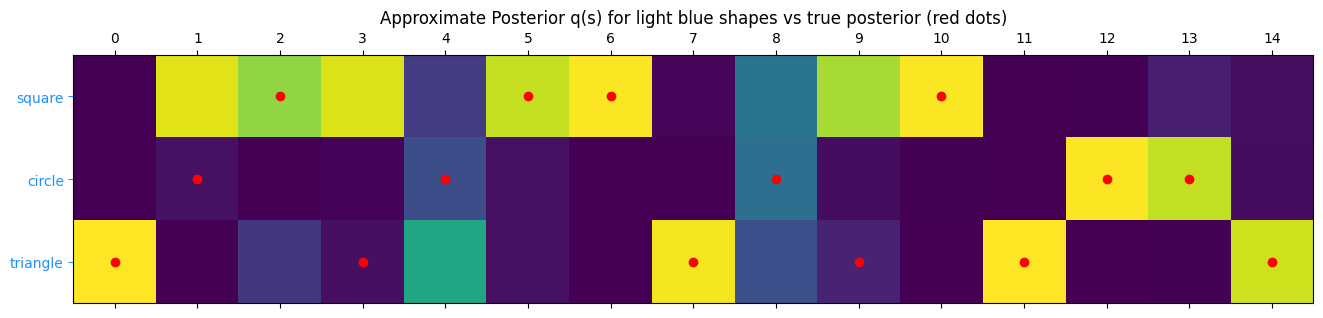

In [227]:
plt.matshow(qs_arr[0].T, vmin = 0.0, vmax = 1.0)
plt.xticks(range(time_steps))
plt.yticks(range(3),['square', 'circle', 'triangle'])
plt.tick_params(axis='y', colors='dodgerblue')
plt.plot(range(time_steps), light_blue_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light blue shapes vs true posterior (red dots)')
plt.show()

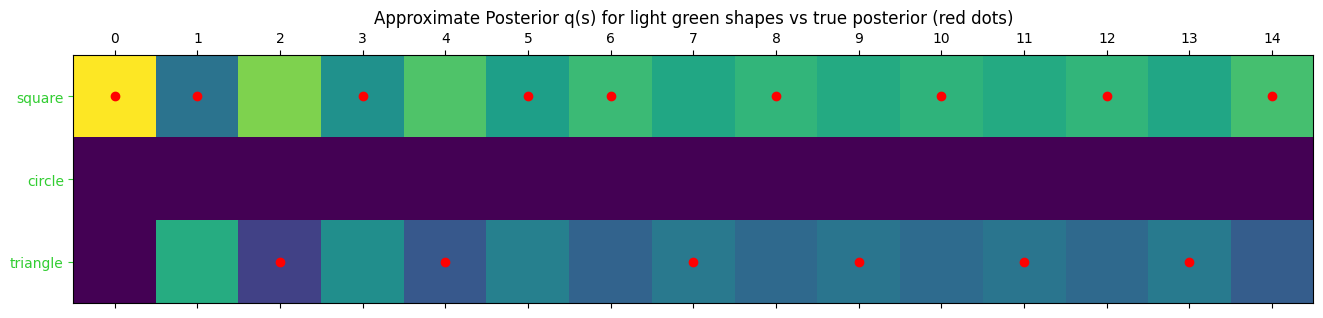

In [228]:
plt.matshow(qs_arr[1].T, vmin = 0.0, vmax = 1.0)
plt.xticks(range(time_steps))
plt.yticks(range(3),['square', 'circle', 'triangle'])
plt.tick_params(axis='y', colors='limegreen')
plt.plot(range(time_steps), light_green_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light green shapes vs true posterior (red dots)')
plt.show()

## Marginal Message Passing

In [17]:
light_blue_shapes_ts.T
B_T = softmax(light_blue_shapes_ts.T)

B_T[1].sum()



0.9791145299460761

In [210]:
A = [
    light_blue_shapes_os,
    light_green_shapes_os
]

B = [
    light_blue_shapes_ts,
    light_green_shapes_ts
]

B_T = [
    softmax(b.T) for b in B
]

D = [
    light_blue_shapes_ps,
    light_green_shapes_ps
]

num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

# qs_arr = np.ones((time_steps, len(D))) / len(D) # array of approximate posteriors q(s) at each time step

qs_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]

qs_history = np.zeros((num_factors, num_iter, time_steps, 3))

# for t in range(time_steps):

for tau in range(time_steps):
    for i in range(num_iter):
        for f in range(num_factors):

            q_s = qs_arr[f][tau]

            if tau == 0:
                log_B_past = np.log(D[f] + _eps)
            else:
                log_B_past = np.log(B[f] @ qs_arr[f][tau - 1] + _eps)

            if tau == time_steps - 1:
                log_B_future = 0
            else:
                log_B_future = np.log(B_T[f] @ qs_arr[f][tau + 1] + _eps)

            log_A = np.log(A[f].T @ outs[tau] + _eps)

                
            q_s = 0.5 * (log_B_past + log_B_future) + log_A

            # print(q_s)
            qs_arr[f][tau] = softmax(q_s)

            qs_history[f][i, tau] = qs_arr[f][tau]

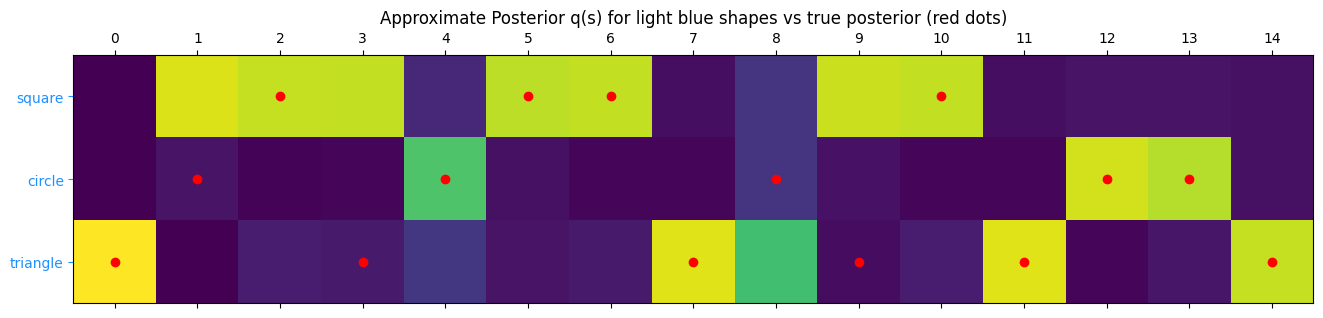

In [211]:
plt.matshow(qs_arr[0].T, vmin = 0.0, vmax = 1.0)
plt.xticks(range(time_steps))
plt.yticks(range(3),['square', 'circle', 'triangle'])
plt.tick_params(axis='y', colors='dodgerblue')
plt.plot(range(time_steps), light_blue_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light blue shapes vs true posterior (red dots)')
plt.show()

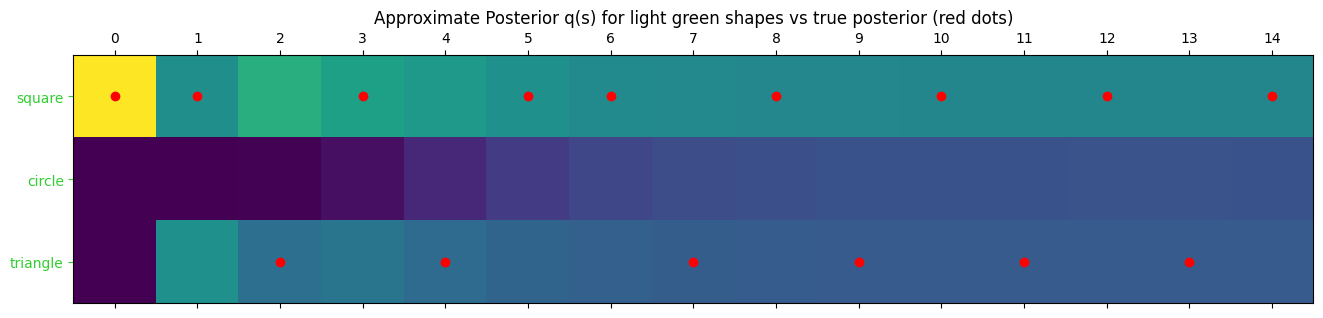

In [212]:
plt.matshow(qs_arr[1].T, vmin = 0.0, vmax = 1.0)
plt.xticks(range(time_steps))
plt.yticks(range(3),['square', 'circle', 'triangle'])
plt.tick_params(axis='y', colors='limegreen')
plt.plot(range(time_steps), light_green_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light green shapes vs true posterior (red dots)')
plt.show()

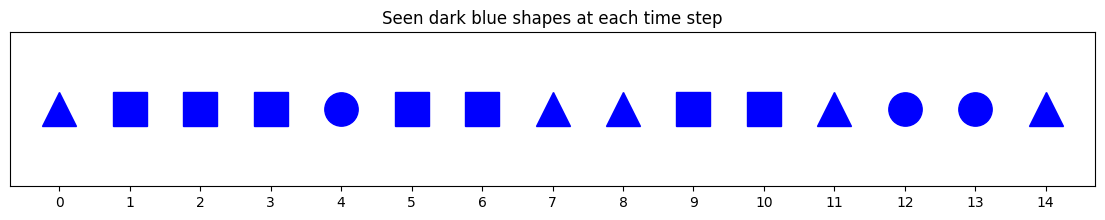

In [173]:
indices_to_shapes = ['s', 'o', '^']
colors = ['blue'] * len(out_indices)

plt.figure(figsize=(14, 2)) 
for i, (shape_index, color) in enumerate(zip(out_indices, colors)):
    plt.plot(i, 1, marker=indices_to_shapes[shape_index], markersize=24, color=color, linestyle='None')

plt.xticks(range(time_steps))
plt.yticks([])
plt.title('Seen dark blue shapes at each time step')
plt.show()

(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)
(15, 3)


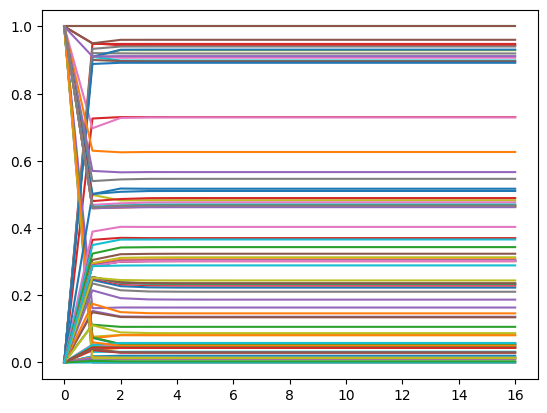

In [174]:
for i, qs_factor_hist in enumerate(qs_history):
    for j in range(qs_factor_hist.shape[1]):
        # print(D[i].shape)
        print(qs_factor_hist[j, :, :].shape)
        # print(np.vstack([D[i], qs_factor_hist[:, j, :]]).shape)
        plt.plot(np.vstack([D[i], qs_factor_hist[:, j, :]]))
        # plt.plot(np.vstack([D[i], qs_factor_hist[j]]))
        # plt.plot(np.vstack([D[i], qs_history[:, j, :]]))

In [66]:
outs[tau]

array([0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.])